### 당일치기, 숙박 여행자 분류 모델
### -> 무엇을 위해서?
### -> 해당 예산으로 어떤 여행을 할 수 있는지, 당일치와 숙박으로 할 수 있는지 확인

In [2]:
import pandas as pd

base_path = r'C:\Users\hanaj\OneDrive\문서\[강남구혁신인재육성아카데미]데이터분석\미니프로젝트\국내여행로그데이터'
sub_place = ['동부권', '서부권', '수도권', '제주도 및 도서지역']
sub_folder = ['TS_csv', 'VS_csv']

# 전국 단위 데이터를 쌓기 위한 리스트
travel_merge = []
accomm_con_merge = []
active_con_merge = []
trans_con_merge = []
pre_con_merge = []

for place in sub_place:
    for folder in sub_folder:
        travel_path = base_path + "\\" + place + "\\" + folder

        suffix = {
            '동부권': 'B',
            '서부권': 'C',
            '수도권': 'A',
            '제주도 및 도서지역': 'D'
        }[place]

        travel = pd.read_csv(travel_path + f"\\tn_travel_여행_{suffix}.csv")
        accomm = pd.read_csv(travel_path + f"\\tn_lodge_consume_his_숙박소비내역_{suffix}.csv")
        active = pd.read_csv(travel_path + f"\\tn_activity_consume_his_활동소비내역_{suffix}.csv")
        trans = pd.read_csv(travel_path + f"\\tn_mvmn_consume_his_이동수단소비내역_{suffix}.csv")
        pre = pd.read_csv(travel_path + f"\\tn_adv_consume_his_사전소비내역_{suffix}.csv")

        travel_merge.append(travel)
        accomm_con_merge.append(accomm)
        active_con_merge.append(active)
        trans_con_merge.append(trans)
        pre_con_merge.append(pre)

# ==== 여기서부터 전국 단위 합치기 ====
travel_merge_all = pd.concat(travel_merge).reset_index(drop=True)
accomm_con_merge_all = pd.concat(accomm_con_merge).reset_index(drop=True)
active_con_merge_all = pd.concat(active_con_merge).reset_index(drop=True)
trans_con_merge_all = pd.concat(trans_con_merge).reset_index(drop=True)
pre_con_merge_all = pd.concat(pre_con_merge).reset_index(drop=True)

travel_merge_all['TRAVEL_END_YMD'] = pd.to_datetime(travel_merge_all['TRAVEL_END_YMD'])
travel_merge_all['TRAVEL_START_YMD'] = pd.to_datetime(travel_merge_all['TRAVEL_START_YMD'])
travel_merge_all['TRAVEL_DAYS'] = (travel_merge_all['TRAVEL_END_YMD'] - travel_merge_all['TRAVEL_START_YMD']).dt.days

TravelID = travel_merge_all[['TRAVEL_ID', 'TRAVEL_DAYS']]
accomm_con_sel = accomm_con_merge_all[['TRAVEL_ID', 'LODGING_TYPE_CD', 'PAYMENT_AMT_WON']].rename(columns={'PAYMENT_AMT_WON': '숙박결제금액'})
active_con_sel = active_con_merge_all[['TRAVEL_ID', 'PAYMENT_AMT_WON']].rename(columns={'PAYMENT_AMT_WON': '활동결제금액'})
trans_con_sel = trans_con_merge_all[['TRAVEL_ID', 'PAYMENT_AMT_WON']].rename(columns={'PAYMENT_AMT_WON': '교통결제금액'})
pre_con_sel = pre_con_merge_all[['TRAVEL_ID', 'PAYMENT_AMT_WON']].rename(columns={'PAYMENT_AMT_WON': '사전결제금액'})

accomm_drop = accomm_con_sel.drop_duplicates(subset=['TRAVEL_ID', 'LODGING_TYPE_CD', '숙박결제금액'])
accomm_sum = accomm_drop.groupby(['TRAVEL_ID', 'LODGING_TYPE_CD'], as_index=False)['숙박결제금액'].sum()
active_sum = active_con_sel.groupby(['TRAVEL_ID'], as_index=False)['활동결제금액'].sum()
trans_sum = trans_con_sel.groupby(['TRAVEL_ID'], as_index=False)['교통결제금액'].sum()
pre_con_sum = pre_con_sel.groupby(['TRAVEL_ID'], as_index=False)['사전결제금액'].sum()

all_merge = pd.merge(TravelID, accomm_sum, on='TRAVEL_ID', how='left')
all_merge = pd.merge(all_merge, active_sum, on='TRAVEL_ID', how='left')
all_merge = pd.merge(all_merge, trans_sum, on='TRAVEL_ID', how='left')
all_merge = pd.merge(all_merge, pre_con_sum, on='TRAVEL_ID', how='left')

all_merge['전체결제금액'] = all_merge[['활동결제금액', '교통결제금액', '사전결제금액']].sum(axis=1, skipna=True)

day_trip = all_merge[all_merge['LODGING_TYPE_CD'].isna()].reset_index(drop=True)
lodgment = all_merge[all_merge['LODGING_TYPE_CD'].notna()].reset_index(drop=True)

long_trip = day_trip[day_trip['TRAVEL_DAYS'] >= 3]
lodgment = pd.concat([lodgment, long_trip], ignore_index=True)
day_trip = day_trip[day_trip['TRAVEL_DAYS'] < 3]

day_trip = day_trip[day_trip['TRAVEL_DAYS'] < 10]
lodgment = lodgment[lodgment['TRAVEL_DAYS'] < 10]

lodgment = lodgment.drop_duplicates('TRAVEL_ID', keep='first')
day_trip['하루평균결제금액'] = day_trip['전체결제금액'] / day_trip['TRAVEL_DAYS']
lodgment['하루평균결제금액'] = lodgment['전체결제금액'] / lodgment['TRAVEL_DAYS']

display(day_trip)
display(lodgment)

,TRAVEL_ID,TRAVEL_DAYS,LODGING_TYPE_CD,숙박결제금액,활동결제금액,교통결제금액,사전결제금액,전체결제금액,하루평균결제금액
0,b_b015715,1,NaN,NaN,38900.0,50200.0,NaN,89100.0,89100.0
1,b_b000419,2,NaN,NaN,183000.0,123000.0,NaN,306000.0,153000.0
2,b_b013638,1,NaN,NaN,120400.0,52800.0,NaN,173200.0,173200.0
3,b_b007836,1,NaN,NaN,118000.0,52900.0,NaN,170900.0,170900.0
4,b_b010123,1,NaN,NaN,132400.0,94400.0,NaN,226800.0,226800.0
...,...,...,...,...,...,...,...,...,...
7157,d_d003501,1,NaN,NaN,54200.0,15500.0,NaN,69700.0,69700.0
7158,d_d002686,1,NaN,NaN,41300.0,10440.0,NaN,51740.0,51740.0
7160,d_d012290,1,NaN,NaN,134500.0,30000.0,NaN,164500.0,164500.0
7161,d_d002993,2,NaN,NaN,118400.0,30000.0,9200.0,157600.0,78800.0


,TRAVEL_ID,TRAVEL_DAYS,LODGING_TYPE_CD,숙박결제금액,활동결제금액,교통결제금액,사전결제금액,전체결제금액,하루평균결제금액
0,b_b004718,2,1.0,114950.0,74360.0,38000.0,NaN,112360.0,56180.000000
1,b_b001944,3,1.0,338000.0,353400.0,113000.0,8900.0,475300.0,158433.333333
2,b_b005554,3,3.0,230000.0,78500.0,72360.0,45000.0,195860.0,65286.666667
3,b_b011374,2,11.0,60075.0,116930.0,57500.0,NaN,174430.0,87215.000000
4,b_b004400,2,1.0,278070.0,115100.0,59200.0,NaN,174300.0,87150.000000
...,...,...,...,...,...,...,...,...,...
8918,d_d001048,3,NaN,NaN,351000.0,19000.0,NaN,370000.0,123333.333333
8919,c_c000890,3,NaN,NaN,215300.0,210000.0,112760.0,538060.0,179353.333333
8920,d_d001511,3,NaN,NaN,106910.0,30350.0,NaN,137260.0,45753.333333
8921,d_d006862,3,NaN,NaN,63000.0,112600.0,NaN,175600.0,58533.333333


              precision    recall  f1-score   support

        당일치기       0.92      0.86      0.89      1351
          숙박       0.88      0.94      0.91      1526

    accuracy                           0.90      2877
   macro avg       0.90      0.90      0.90      2877
weighted avg       0.90      0.90      0.90      2877



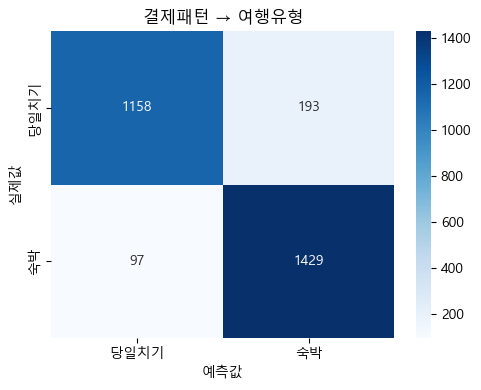

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

day_trip = day_trip.copy()
lodgment = lodgment.copy()

day_trip['target'] = 0
lodgment['target'] = 1

df_all = pd.concat([day_trip, lodgment], ignore_index=True)

y = df_all['target'].astype(int)
x = df_all[['활동결제금액', '교통결제금액', '사전결제금액', '하루평균결제금액']].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['당일치기','숙박']))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['당일치기','숙박'], yticklabels=['당일치기','숙박'])
plt.title('결제패턴 → 여행유형')
plt.xlabel('예측값'); plt.ylabel('실제값')
plt.tight_layout(); plt.show()